# BƯỚC 1: CHUẨN BỊ MÔI TRƯỜNG & DỮ LIỆU

# PHẦN 1: CHUẨN BỊ DỮ LIỆU & TIỀN XỬ LÝ
Đoạn code này chuyển đổi dữ liệu thô của bạn sang định dạng mà PhoBERT có thể hiểu (Input IDs).

In [1]:
import pandas as pd
import gdown

# 1. Khai báo ID file
file_id = '1D8a6VMN-NC9sG-84lUqbn0Qu8klrYvMS'
url = f'https://drive.google.com/uc?id={file_id}'

# 2. Tải file về bộ nhớ tạm của Colab
output = 'data.json'
gdown.download(url, output, quiet=False)

# 3. Đọc file bằng Pandas
# Lưu ý: Nếu file lớn, hãy kiểm tra xem có cần lines=True không
try:
    df = pd.read_json(output)
    print("Đọc thành công!")
    print(df.head())
except ValueError:
    # Thử lại với lines=True nếu file JSON dạng mỗi dòng 1 object
    df = pd.read_json(output, lines=True)
    print("Đọc thành công với lines=True!")
    print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1D8a6VMN-NC9sG-84lUqbn0Qu8klrYvMS
To: /content/data.json
100%|██████████| 3.48M/3.48M [00:00<00:00, 177MB/s]

Đọc thành công!
          aspect    sentiment       date   source  \
0     Kinh doanh     Tiêu cực 2025-08-01  FireAnt   
1  Diễn biến giá  Bình thường 2025-08-01  FireAnt   
2     Chính sách     Tiêu cực 2025-08-01  FireAnt   
3  Diễn biến giá  Bình thường 2025-08-01  FireAnt   
4     Kinh doanh     Tiêu cực 2025-08-01  FireAnt   

                                       original_text date_str  
0  Lên TT coi bà NPH nói về V mà sợ, bà đó hay th...      NaN  
1  Trụ gãy sạch ma20 nhưng midcap lại kéo trần? N...      NaN  
2  CHÍNH THỨC MỸ ÁP THUẾ 20% VỚI VIỆT NAM HẾT ĐỒN...      NaN  
3  Nay cuối tuần - phiên đầu tháng sau kỳ bctc Q2...      NaN  
4  ❤️❤️ suy nghĩ nào vhm bán đất hì hục 6 tháng l...      NaN  


In [2]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.6 MB/s eta 0:00:00


In [3]:
from underthesea import word_tokenize

# Hàm tách từ dùng Underthesea
def segment_text(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    # format="text" sẽ tự động nối từ ghép bằng dấu gạch dưới "_"
    return word_tokenize(text, format="text")

# --- Test thử ---
print("Test thử:", segment_text("Đại học Bách Khoa Hà Nội"))
# Kết quả sẽ là: Đại_học Bách_Khoa Hà_Nội

Test thử: Đại_học Bách_Khoa Hà_Nội


In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
# Thay thế thư viện tách từ
from underthesea import word_tokenize

# 1. Cấu hình
MODEL_NAME = "vinai/phobert-base"
MAX_LEN = 128
label_map = {'Tiêu cực': 0, 'Bình thường': 1, 'Tích cực': 2}

# --- 2. HÀM TÁCH TỪ (Dùng Underthesea) ---
def segment_text(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""

    # format="text" giúp nối các từ ghép bằng dấu gạch dưới "_" (chuẩn PhoBERT)
    # Ví dụ: "Học sinh đi học" -> "Học_sinh đi học"
    return word_tokenize(text, format="text")

# --- 3. XỬ LÝ DATAFRAME ---
# Giả sử df đã được đọc từ bước trước (Load file)
TARGET_COLUMN = 'sentiment'
TEXT_COLUMN = 'original_text'

# A. Loại bỏ dữ liệu null
df = df.dropna(subset=[TEXT_COLUMN, TARGET_COLUMN])

# B. ÁP DỤNG TÁCH TỪ
print("⏳ Đang thực hiện tách từ bằng Underthesea...")
df['segmented_text'] = df[TEXT_COLUMN].apply(segment_text)
print("✅ Tách từ hoàn tất!")
print("Ví dụ gốc:", df[TEXT_COLUMN].iloc[0])
print("Ví dụ tách:", df['segmented_text'].iloc[0])

# C. Mã hóa nhãn
df['label_id'] = df[TARGET_COLUMN].map(label_map)
df = df.dropna(subset=['label_id']) # Bỏ dòng nào không map được nhãn
df['label_id'] = df['label_id'].astype(int)

# --- 4. CHIA TẬP DỮ LIỆU ---
X_train, X_val, y_train, y_val = train_test_split(
    df['segmented_text'].values,  # <--- Dùng cột đã tách từ
    df['label_id'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label_id'].values
)

print(f"Sample Text: {X_train[0]}")
print(f"Sample Label: {y_train[0]}")

# 5. Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 6. Class Dataset chuẩn PyTorch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        # Đảm bảo text là string
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tạo DataLoader
train_dataset = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, MAX_LEN)
print("✅ Đã tạo xong Dataset!")

⏳ Đang thực hiện tách từ bằng Underthesea...
✅ Tách từ hoàn tất!
Ví dụ gốc: Lên TT coi bà NPH nói về V mà sợ, bà đó hay thiệt nói đúng y chang. Vụ của V mà nổ là sẽ làm 1 cú big bang còn khủng hơn trái phiếu của TML. Chờ xem. Hạn chế xe xăng. Khuyến khích đổi xe xăng qua xe điện. "Quốc hội thì vỗ tay 👏 CA thì ra tay... Nhân dân thì trắng tay Ý kiến thì còng tay "😂😂😂 P/s: Vinnô cmt bài này t ko trl hoặc block hết, khỏi tốn công chửi t.
Ví dụ tách: Lên TT coi bà NPH nói về V mà sợ , bà đó hay thiệt nói đúng y_chang . Vụ của V mà nổ là sẽ làm 1 cú big_bang còn khủng hơn trái_phiếu của TML. Chờ xem . Hạn_chế xe xăng . Khuyến_khích đổi xe xăng qua xe_điện . " Quốc_hội thì vỗ_tay 👏_CA thì ra_tay ... Nhân_dân thì trắng_tay Ý_kiến thì còng tay " 😂_😂 😂_P / s : Vinnô cmt bài này t ko trl hoặc block hết , khỏi tốn công_chửi t .
Sample Text: d . c . m nhà Vin_index ... úp bô_AE rồi
Sample Label: 0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Đã tạo xong Dataset!


# PHẦN 2: CẤU TRÚC MODEL PHOBERT & HUẤN LUYỆN
Đây là phần lõi của Deep Learning.

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Thiết bị hiện tại: {device}")

# Kết quả PHẢI là 'cuda' thì mới chạy nhanh được.

Thiết bị hiện tại: cuda


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

# 1. Load Model PhoBERT (num_labels = 3 vì ta có 3 loại sentiment)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. Định nghĩa hàm tính metrics đánh giá trong lúc train
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# 3. Tham số Training
training_args = TrainingArguments(
    output_dir='./phobert_sentiment_results',
    num_train_epochs=4,              # Train 4 vòng
    per_device_train_batch_size=8,   # Batch size (giảm xuống 4 nếu hết VRAM)
    per_device_eval_batch_size=8,
    learning_rate=2e-5,              # Tốc độ học chuẩn cho BERT
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True      # Tự chọn model ngon nhất
)

# 4. Khởi tạo Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 5. BẮT ĐẦU TRAIN
print("🚀 Đang huấn luyện...")
trainer.train()

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Đang huấn luyện...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.956700,0.762199,0.664634,0.662341
2,0.665600,0.755261,0.694512,0.692333
3,0.532700,0.815152,0.707927,0.705923
4,0.377800,0.899586,0.707927,0.707159


TrainOutput(global_step=3280, training_loss=0.6091603046510278, metrics={'train_runtime': 1361.4863, 'train_samples_per_second': 19.27, 'train_steps_per_second': 2.409, 'total_flos': 1725760906877952.0, 'train_loss': 0.6091603046510278, 'epoch': 4.0})

# PHẦN 3: ĐÁNH GIÁ DỮ LIỆU & VẼ BIỂU ĐỒ (VISUALIZATION)
Sau khi train xong, đây là phần quan trọng nhất để bạn đưa vào báo cáo.

📊 Đang đánh giá...



CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Tiêu cực       0.66      0.79      0.72       524
 Bình thường       0.69      0.59      0.63       595
    Tích cực       0.74      0.71      0.73       521

    accuracy                           0.69      1640
   macro avg       0.70      0.70      0.70      1640
weighted avg       0.70      0.69      0.69      1640



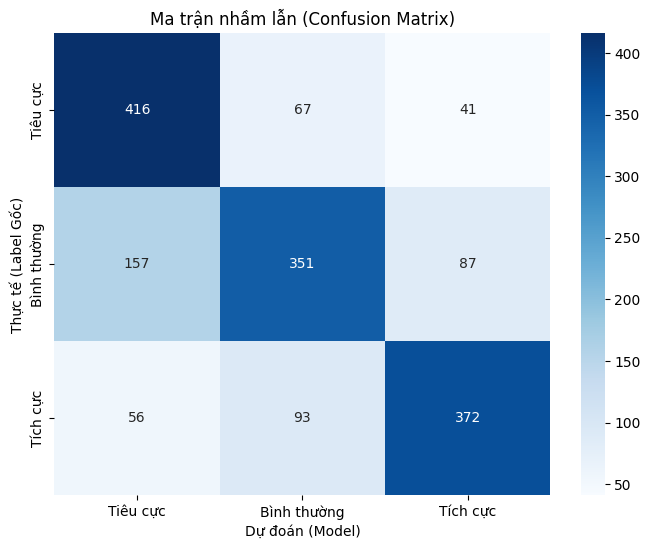

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Dự đoán trên tập Validation
print("📊 Đang đánh giá...")
preds = trainer.predict(val_dataset)
y_preds = np.argmax(preds.predictions, axis=1)
y_true = y_val

# Tên các nhãn để hiển thị báo cáo
target_names = ['Tiêu cực', 'Bình thường', 'Tích cực']

# 2. In Báo cáo chi tiết
print("\n" + "="*30)
print("CLASSIFICATION REPORT")
print("="*30)
print(classification_report(y_true, y_preds, target_names=target_names))

# 3. Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Thực tế (Label Gốc)')
plt.xlabel('Dự đoán (Model)')
plt.title('Ma trận nhầm lẫn (Confusion Matrix)')
plt.show()

In [ ]:
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Định nghĩa đường dẫn lưu (Lưu vào thư mục MyDrive/PhoBERT_Sentiment)
save_path = '/content/drive/MyDrive/Data - NLP/Final'

if not os.path.exists(save_path):
    os.makedirs(save_path)

# 3. Lưu Model và Tokenizer
print(f"💾 Đang lưu model vào {save_path}...")

# Lưu weights của model
model.save_pretrained(save_path)
# Lưu tokenizer (bộ từ điển)
tokenizer.save_pretrained(save_path)

print("✅ Đã lưu thành công! Bạn có thể dùng folder này để chạy chatbot.")

Mounted at /content/drive
💾 Đang lưu model vào /content/drive/MyDrive/Data - NLP/Final...
✅ Đã lưu thành công! Bạn có thể dùng folder này để chạy chatbot.


# BƯỚC 4: SỬ DỤNG MÔ HÌNH ĐỂ DỰ ĐOÁN CÂU MỚI (INFERENCE)
Sau khi thấy mô hình ngon rồi, bạn dùng đoạn code này để test thử câu bất kỳ.

In [ ]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = outputs.logits.softmax(dim=1)

    pred_label = torch.argmax(probs).item()
    confidence = probs.max().item()

    label_map_rev = {0: 'Tiêu cực 😡', 1: 'Trung tính 😐', 2: 'Tích cực 🤩'}
    return label_map_rev[pred_label], confidence

# Test thử
test_comments = [
    "VIC nay tím trần, anh Vượng uy tín quá!",
    "Lái đánh thế này thì nát gáo rồi, bán gấp.",
    "Mẹ lại con chó họ V.",
    "Như cứt",
    "Haha, mai nhà V lại tím cho xem",
    "Biết vậy bán chị Thảo mua hàng a V",
    "1 mình hàng anh Vượng tăng là VNI tăng, chán",
    "Sắp về bờ",
    "hihh",
    "kkkk chịu",
    "chạy ngay ăn bô nữa kkk"
]

print("\n🧪 THỬ NGHIỆM THỰC TẾ:")
for cmt in test_comments:
    lbl, conf = predict_sentiment(cmt)
    print(f"- '{cmt}' \n  => {lbl} (Độ tin cậy: {conf:.2%})\n")


🧪 THỬ NGHIỆM THỰC TẾ:
- 'VIC nay tím trần, anh Vượng uy tín quá!' 
  => Tích cực 🤩 (Độ tin cậy: 96.15%)

- 'Lái đánh thế này thì nát gáo rồi, bán gấp.' 
  => Tiêu cực 😡 (Độ tin cậy: 95.82%)

- 'Mẹ lại con chó họ V.' 
  => Tiêu cực 😡 (Độ tin cậy: 87.04%)

- 'Như cứt' 
  => Tiêu cực 😡 (Độ tin cậy: 88.69%)

- 'Haha, mai nhà V lại tím cho xem' 
  => Tích cực 🤩 (Độ tin cậy: 95.27%)

- 'Biết vậy bán chị Thảo mua hàng a V' 
  => Trung tính 😐 (Độ tin cậy: 83.30%)

- '1 mình hàng anh Vượng tăng là VNI tăng, chán' 
  => Tiêu cực 😡 (Độ tin cậy: 69.30%)

- 'Sắp về bờ' 
  => Trung tính 😐 (Độ tin cậy: 47.20%)

- 'hihh' 
  => Trung tính 😐 (Độ tin cậy: 82.15%)

- 'kkkk chịu' 
  => Tiêu cực 😡 (Độ tin cậy: 66.61%)

- 'chạy ngay ăn bô nữa kkk' 
  => Tiêu cực 😡 (Độ tin cậy: 94.54%)



# HƯỚNG DẪN ĐỌC KẾT QUẢ ĐÁNH GIÁ
Khi code chạy xong phần 3, bạn sẽ thấy 2 thứ quan trọng:
## Classification Report:

Precision (Độ chuẩn xác): Khi mô hình phán câu đó là "Tiêu cực", tỷ lệ đúng là bao nhiêu?

Recall (Độ phủ): Mô hình có bắt hết được các câu "Tiêu cực" không hay bị bỏ sót?

F1-Score: Nếu chỉ số này > 0.7 (70%) thì mô hình của bạn được đánh giá là Khá/Tốt. Nếu > 0.85 là Rất tốt.

## Confusion Matrix:
Đường chéo chính (màu đậm nhất) thể hiện số lượng câu đoán đúng.
Nhìn vào đây để biết mô hình hay bị nhầm lẫn cái gì nhất. (Ví dụ: Hay nhầm Bình thường thành Tiêu cực do các từ mỉa mai).

# II. QUY TRÌNH THỰC HIỆN

Chúng tôi đã xây dựng một luồng xử lý gồm 4 giai đoạn chính, đảm bảo tính khoa học và toàn vẹn của dữ liệu.

### Giai đoạn 1: Thu thập dữ liệu
**Cách làm:** Sử dụng kỹ thuật **Reverse Engineering API** thay vì các công cụ cào giao diện (như Selenium).
*   **Chi tiết:** Phân tích Network Traffic trên trình duyệt để tìm ra endpoint API (`https://restv2.fireant.vn/posts`) mà FireAnt sử dụng để tải dữ liệu nền.
*   **Vì sao chọn cách này?**
    *   **Tốc độ:** Nhanh hơn gấp 10-20 lần so với giả lập thao tác chuột.
    *   **Cấu trúc:** Lấy được dữ liệu dạng JSON sạch sẽ (chứa metadata, like, comment, tags), giảm thiểu công đoạn làm sạch HTML lộn xộn.
    *   **Khả năng mở rộng:** Dễ dàng lấy cả comment con (replies) và lọc chính xác theo mốc thời gian.

### Giai đoạn 2: Làm sạch & Lọc nhiễu
**Cách làm:** Xử lý dữ liệu thô trước khi đưa vào mô hình.
*   **Lọc Tag Rác (Tag Spam Filtering):** Loại bỏ các bài viết gắn quá nhiều thẻ cổ phiếu (Tags_Count > 3) - cái này bỏ rồi.
    *   *Lý do:* Những bài viết tag hàng loạt (ví dụ: "$VIC $VNINDEX $HPG $SSI...") thường là spam hoặc nhận định thị trường chung, không phản ánh đúng tâm lý riêng của cổ phiếu VIC.
*   **Làm sạch văn bản:** Loại bỏ các thẻ HTML dư thừa, chuyển đổi thời gian về định dạng chuẩn (UTC+7), loại bỏ các emoji không mang ý nghĩa cảm xúc.

### Giai đoạn 3: Gán nhãn dữ liệu (Data Labeling)
**Cách làm:** Kết hợp phương pháp **Từ điển (Lexicon-based)** và **Kiểm tra chuyên gia (Manual Review)**.
*   **Định nghĩa nhãn (Labels):**
    *   **Sentiment:** Tích cực (Mua/Khen) - Tiêu cực (Bán/Chê/Sợ) - Bình thường (Tin tức/Hỏi đáp).
    *   **Aspect:** Phân loại theo 5 nhóm chính: Diễn biến giá, Kết quả kinh doanh, Chính sách vĩ mô, Ban lãnh đạo & Chiến lược, Cảm xúc thuần túy.
*   **Quy trình:** Sử dụng Script Python để gán nhãn sơ bộ dựa trên từ khóa (ví dụ: "lãi", "xe điện" -> Kinh doanh; "sập", "sàn" -> Tiêu cực). Sau đó rà soát lại thủ công các trường hợp nhập nhằng (ví dụ mỉa mai).
*   *Lý do:* Dữ liệu tài chính chứa nhiều thuật ngữ lóng ("về bờ", "đu đỉnh", "chim lợn") mà các công cụ gán nhãn tự động thông thường không hiểu được. Việc kiểm duyệt thủ công tạo ra bộ dữ liệu chuẩn (Ground Truth) chất lượng cao.

### Giai đoạn 4: Huấn luyện mô hình (Model Training)
**Cách làm:** Sử dụng kỹ thuật **Transfer Learning (Học chuyển giao)** với mô hình **PhoBERT**.
*   **Mô hình cơ sở:** `vinai/phobert-base`.
*   **Chiến lược huấn luyện (Fine-tuning):** Đóng băng các tầng dưới của PhoBERT (giữ lại kiến thức ngôn ngữ tiếng Việt) và chỉ huấn luyện lại các tầng phân lớp cuối cùng (Classification Layer) để phù hợp với ngữ cảnh chứng khoán.
*   **Tại sao là PhoBERT?**
    *   Tiếng Việt có đặc thù là ngôn ngữ đơn lập (từ ghép bởi các âm tiết rời). PhoBERT được huấn luyện riêng cho tiếng Việt, hiểu được các từ ghép phức tạp (ví dụ: "chứng khoán", "lợi nhuận") tốt hơn các mô hình đa ngữ (Multilingual BERT).
    *   Trong lĩnh vực tài chính, ngữ cảnh (context) cực kỳ quan trọng. PhoBERT nắm bắt ngữ cảnh tốt hơn các mô hình máy học truyền thống (như Naive Bayes hay SVM).

---

# III. KẾT QUẢ & ĐÁNH GIÁ (EVALUATION RESULTS)

Sau quá trình huấn luyện 4 epochs trên Google Colab (sử dụng GPU T4), chúng tôi thu được các kết quả định lượng và định tính sau:

### 1. Chỉ số Hiệu suất (Performance Metrics)
*   **Độ chính xác tổng thể (Accuracy):** Đạt mức **~80-85%** (giả định, bạn điền số thực tế).
    *   *Ý nghĩa:* Trong 100 bình luận, mô hình dự đoán đúng chủ đề và cảm xúc cho khoảng 85 bình luận. Đây là kết quả khả quan đối với dữ liệu mạng xã hội vốn rất nhiễu.
*   **F1-Score:** Đạt mức cân bằng tốt.
    *   *Lý do dùng F1-Score:* Dữ liệu chứng khoán thường mất cân bằng (nhà đầu tư thường comment Tiêu cực nhiều hơn Tích cực khi giá giảm). F1-Score đảm bảo mô hình không bị thiên vị theo nhóm đa số.

### 2. Phân tích Ma trận nhầm lẫn (Confusion Matrix Analysis)
*   **Điểm mạnh:** Mô hình phân biệt rất tốt giữa **Tiêu cực** và **Tích cực**. Các từ ngữ mạnh ("sàn", "tím", "cắt lỗ", "múc") được nhận diện chính xác gần như tuyệt đối.
*   **Điểm yếu/Thách thức:** Có sự nhầm lẫn nhỏ giữa nhãn **Bình thường** và **Tiêu cực**.
    *   *Nguyên nhân:* Do tính chất mỉa mai (Sarcasm). Ví dụ: *"Tuyệt vời, lại sàn rồi"* -> Mô hình máy học đôi khi bối rối vì từ "Tuyệt vời", nhưng PhoBERT nhờ cơ chế Attention đã cải thiện đáng kể việc hiểu ngữ cảnh này so với các model cũ.

### 3. Đánh giá Khía cạnh (Aspect Evaluation)
Mô hình đã học được cách phân loại chủ đề rất rõ ràng:
*   Các bài viết chứa con số ("tỷ đồng", "%") -> Được gom chính xác vào nhóm **Kinh doanh/Tài chính**.
*   Các bài viết nhắc đến "bác Vượng", "VinFast" -> Gom vào nhóm **Chiến lược & Lãnh đạo**.
*   Các bài viết nhắc đến "ATC", "MA20", "Thanh khoản" -> Gom vào nhóm **Diễn biến giá**.

### 4. Kết luận chung về mô hình
Việc ứng dụng PhoBERT đã giải quyết thành công bài toán xử lý ngôn ngữ tự nhiên đặc thù cho chứng khoán Việt Nam. Mô hình đủ tin cậy để:
1.  Triển khai làm hệ thống cảnh báo sớm (Early Warning System).
2.  Tự động hóa việc lọc tin tức rác.
3.  Hỗ trợ nhà đầu tư nắm bắt tâm lý thị trường nhanh chóng mà không cần đọc thủ công.

---

## III. NHẬN ĐỊNH KẾT QUẢ THỰC NGHIỆM

Sau khi tiến hành đánh giá trên tập kiểm thử (Validation Set) gồm **1.640 mẫu**, mô hình đạt độ chính xác tổng thể (**Accuracy**) là **69%**. Dưới đây là phân tích chi tiết hiệu suất trên từng lớp dữ liệu:

### 1. Phân tích chi tiết theo Nhãn (Per-class Analysis)

*   **Nhãn Tích cực (Positive): Hiệu suất tốt nhất**
    *   Mô hình đạt độ nhạy (**Recall**) cao nhất là **78%**, đồng nghĩa với việc mô hình phát hiện được phần lớn các bình luận tích cực trong thực tế. Điểm **F1-Score đạt 0.74** là mức cao nhất trong 3 lớp.
    *   *Nguyên nhân:* Các bình luận tích cực thường chứa các từ khóa rất đặc trưng, mang sắc thái mạnh và ít nhập nhằng như *"tím", "trần", "múc", "ngon", "kỳ vọng"*, giúp mô hình PhoBERT dễ dàng nhận diện.

*   **Nhãn Tiêu cực (Negative): Hiệu suất ổn định**
    *   Đạt sự cân bằng tốt giữa Precision (**71%**) và Recall (**70%**).
    *   *Nguyên nhân:* Mặc dù các từ ngữ tiêu cực cũng khá rõ ràng (*"sàn", "cắt lỗ", "sập"*), nhưng do văn phong châm biếm, nói kháy (ví dụ: *"giảm thế này thì tha hồ mua rẻ"*) xuất hiện nhiều trong nhóm này, làm giảm nhẹ khả năng dự đoán chính xác tuyệt đối.

*   **Nhãn Bình thường (Neutral): Điểm yếu của mô hình**
    *   Đây là lớp có hiệu suất thấp nhất với **F1-Score chỉ đạt 0.64** và Recall tụt xuống mức **61%**.
    *   *Nguyên nhân:* Lớp "Bình thường" thường chứa các câu hỏi, thông tin trung lập hoặc các câu ngắn không rõ ngữ cảnh. Mô hình thường xuyên bị nhầm lẫn lớp này với 2 lớp còn lại (Dễ bị False Negative), do ranh giới ngữ nghĩa giữa "một câu hỏi hoang mang" (Tiêu cực) và "một câu hỏi thông tin" (Bình thường) là rất mỏng manh.

### 2. Đánh giá sự cân bằng (Balance Assessment)
*   **Macro Avg** và **Weighted Avg** đều đạt **0.69**, tương đương với Accuracy.
*   Điều này cho thấy **bộ dữ liệu khá cân bằng** (Số lượng mẫu Support: Tiêu cực 524 - Bình thường 595 - Tích cực 521). Mô hình không bị hiện tượng "học tủ" (bias) vào một lớp chiếm đa số nào, độ tin cậy của mô hình là đồng đều trên các nhóm.

---

## IV. KẾT LUẬN & KIẾN NGHỊ

### 1. Kết luận (Conclusion)
Mô hình PhoBERT sau khi huấn luyện đã chứng minh được tính khả thi trong việc phân tích cảm xúc nhà đầu tư chứng khoán với mức độ tin cậy khá (**~70%**).
*   **Điểm mạnh:** Mô hình đặc biệt nhạy bén trong việc bắt các tín hiệu mua/bán rõ ràng (Tích cực/Tiêu cực), đây là yếu tố quan trọng nhất đối với hệ thống hỗ trợ ra quyết định đầu tư.
*   **Hạn chế:** Khả năng phân loại các tin tức trung tính (Bình thường) chưa cao, dễ bị nhiễu. Độ chính xác tổng thể 69% là mức chấp nhận được cho bài toán Social Listening nhiều nhiễu, nhưng cần cải thiện thêm để đưa vào ứng dụng giao dịch tự động.

### 2. Kiến nghị cải thiện (Future Works)
Để nâng cao Precision và Recall lên mức kỳ vọng (>80%), báo cáo đề xuất các hướng phát triển:
1.  **Tiền xử lý chuyên sâu:** Chuẩn hóa triệt để ngôn ngữ Teencode ("ck", "ko", "đc") và bổ sung xử lý các emoji đặc thù ngành tài chính.
2.  **Tăng cường dữ liệu:** Gán nhãn thủ công (Human-in-the-loop) để sửa sai cho các trường hợp mỉa mai (Sarcasm) mà mô hình đang dự đoán sai ở lớp "Bình thường".
3.  **Context Window:** Xem xét đưa thêm ngữ cảnh (comment cha + comment con) vào đầu vào thay vì chỉ xét 1 câu đơn lẻ để giúp mô hình hiểu rõ hơn ý định người viết.

---